In [36]:
import sys
import os
import math
import dlib
import glob
from skimage import io
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.color import rgb2gray, gray2rgb


MODEL = "shape_predictor_68_face_landmarks.dat"

In [14]:
%matplotlib inline
import autoanime

In [19]:
def dist(p1,p2):
    return math.sqrt(sum([pow(c1-c2,2) for (c1,c2) in zip(p1,p2)]))
def crop_wrapper(x, y, x_plus, y_plus, im):
    """crops image centered at (x,y) by (x_plus, y_plus) in each direction."""
    print "xplus, yplus: ", x_plus, y_plus
    return im.crop((x-x_plus, y-y_plus, x+x_plus, y+y_plus))

In [20]:
def find_eyebrows(shape, orig_im):
    """returns cropped eyebrows."""
    
    l_eyebrow = [shape.part(17),shape.part(18),shape.part(19),shape.part(20),shape.part(21)]
    r_eyebrow = [shape.part(22),shape.part(23),shape.part(24),shape.part(25),shape.part(26)]

    min_left_eyebrow = min([p.y for p in l_eyebrow])
    min_right_eyebrow = min([p.y for p in r_eyebrow])

    max_left_eye = max(shape.part(37).y, shape.part(38).y)
    max_right_eye = max(shape.part(43).y, shape.part(44).y)

    left_offset = abs(min_left_eyebrow - max_left_eye)
    right_offset = abs(min_right_eyebrow - max_right_eye)

    left_x_offset = max(abs(shape.part(19).x - shape.part(17).x), abs(shape.part(19).x - shape.part(21).x))
    right_x_offset = max(abs(shape.part(24).x - shape.part(22).x), abs(shape.part(24).x - shape.part(26).x))

    left_offset = int(left_offset / 1.5)
    right_offset = int(right_offset / 1.5)

    cropped_left = crop_wrapper(shape.part(19).x, shape.part(19).y, left_x_offset, left_offset, orig_im)
    cropped_right = crop_wrapper(shape.part(24).x, shape.part(24).y, right_x_offset, right_offset, orig_im)

    return cropped_left, cropped_right

In [108]:
def crop_eyes(shape, orig_im):
    """crops eyes, and rescales them to be 110x220."""    
    l_eye = [shape.part(36),shape.part(37),shape.part(38),shape.part(39),shape.part(40),shape.part(41)]
    r_eye = [shape.part(42),shape.part(43),shape.part(44),shape.part(45),shape.part(46),shape.part(47)]

    l_x_min = min([p.x for p in l_eye])
    l_x_max = max([p.x for p in l_eye])
    l_y_min = min([p.y for p in l_eye])
    l_y_max = max([p.y for p in l_eye])

    r_x_min = min([p.x for p in r_eye])
    r_x_max = max([p.x for p in r_eye])
    r_y_min = min([p.y for p in r_eye])
    r_y_max = max([p.y for p in r_eye])

    cropped_l_eye = orig_im.crop((l_x_min-10, l_y_min-10, l_x_max+10, l_y_max+10))
    cropped_r_eye = orig_im.crop((r_x_min-10, r_y_min-10, r_x_max+10, r_y_max+10))
    return cropped_l_eye, cropped_r_eye

In [120]:
def resize(left, right):
    """resizes both eyes to be 110x220, returns them as np.arrays"""
    wl, hl = left.size
    lratio = 220./wl
    wr, hr = right.size
    rratio = 220./wr

    left = left.resize((220, int(hl*lratio)) , resample=Image.BICUBIC)
    right = right.resize((220, int(hr*rratio)) , resample=Image.BICUBIC)
    
    _, new_h_left = left.size
    _, new_h_right = right.size

    left = np.asarray(left)
    right = np.asarray(right)
    
    #er always assume > 110 px now...TODO: increase crop if problem
    crop_l = (new_h_left - 110)/2
    crop_r = (new_h_right - 110)/2    
    if (crop_l > 0):
        left = left[crop_l:new_h_left-crop_l , :]
    if (crop_r > 0):
        right = right[crop_r:new_h_right-crop_r , :]
    return left, right

130 132
10 11


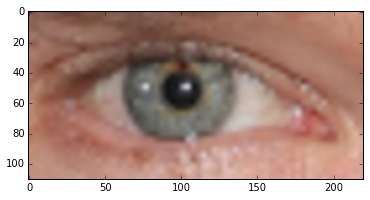

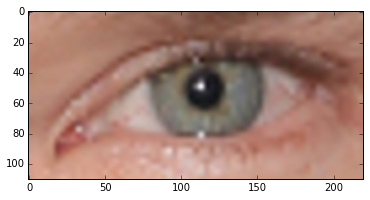

(110, 220, 3)


In [121]:
#main stuff
fname = 'bcum.jpg'
shape = autoanime.predict_shape(fname) #CHANGE
orig_im = Image.open(fname)
new_im = Image.new("RGB", (orig_im.size[0], orig_im.size[1]), color=(255,255,255))

left, right = crop_eyes(shape, orig_im)
left_r, right_r = resize(left, right)
plt.imshow(left_r)
plt.show()
plt.imshow(right_r)
plt.show()
print left_r.shape


In [100]:
def render_big_eyebrows(left, right): 
    """returns true/false if big eyebrows should be drawn or not."""
    left = np.asarray(left)
    right = np.asarray(right)
    l_gradient = np.gradient(rgb2gray(left))
    r_gradient = np.gradient(rgb2gray(right))

    energy_1 = np.zeros((left.shape[0], left.shape[1]))
    energy_r = np.zeros((right.shape[0], right.shape[1]))
    energy_l = abs(l_gradient[0]) 
    energy_r = abs(r_gradient[0]) 
    
    plt.imshow(energy_l,  cmap=cm.Greys_r)
    plt.show()
    plt.imshow(left)
    plt.show()
    plt.imshow(energy_r,  cmap=cm.Greys_r)
    plt.show()
    plt.imshow(right)
    plt.show()
    
    h, w = energy_l.shape
    mid_h = h / 2
    #not sure about these thresholds
    cropped_l = energy_l[mid_h-(h/4):mid_h+(h/4), :]
    cropped_r = energy_r[mid_h-(h/4):mid_h+(h/4), :]
    
    plt.imshow(cropped_l,  cmap=cm.Greys_r)
    plt.show()
    plt.imshow(cropped_r,  cmap=cm.Greys_r)
    plt.show()
    
    s_l = cropped_l.sum() / (cropped_l.shape[0] * cropped_l.shape[1]) 
    s_r = cropped_r.sum() / (cropped_r.shape[0] * cropped_r.shape[1])
    fin_avg = (s_l + s_r) / 2. 
#     print 'finall! ', fin_avg
    if fin < 0.02:
        return False
    else:
        return True
    

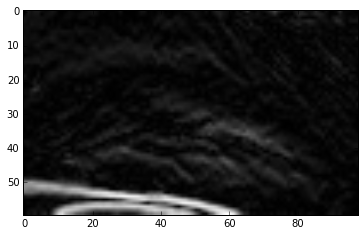

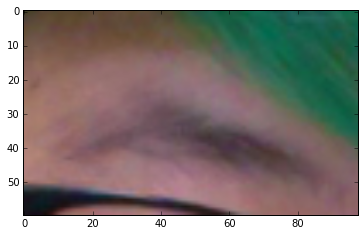

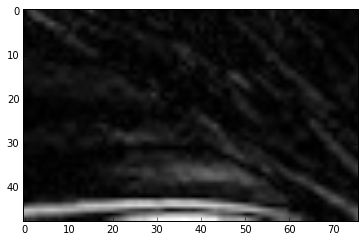

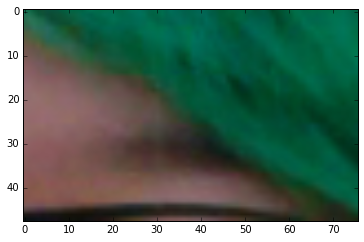

60 98
30


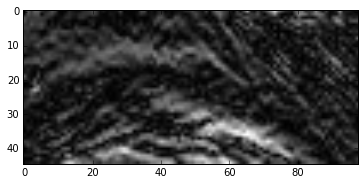

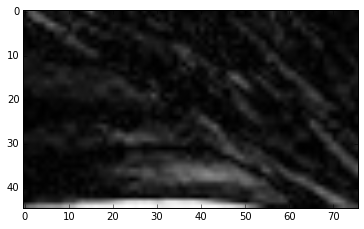

0.0105811378774 0.014320412166


In [90]:
render_big_eyebrows(cropped_left, cropped_right)